## Entropy information analyzer
This is the working pipeline for the identification and classification of entropy drops.

In [10]:
# imports
from utils import *
from stats_utils import *
from fig_utils import *

%matplotlib inline

In [ ]:
#fasta = r'example/sequences.fasta'
fasta = r'/Users/daniellemiller/Google Drive/Msc Bioinformatics/Projects/Entropy/Largest_scaf8.fasta'
out = r'example/output'

# generate profiles
k = 5
w = 1000

shannon = get_entropy_profile(fasta=fasta, w=w, k=k, out=out, data_type='fasta')
joint = get_joint_entropy_profile(fasta=fasta, w=w, k=k, out=out, data_type='fasta')
deltag = get_deltaG_profile(fasta=fasta, w=w, out=out, data_type='fasta')



0it [00:00, ?it/s]
1it [00:25, 25.59s/it]
0it [00:00, ?it/s]

In [3]:
# normalize values to [0,1]

shannon = shannon/shannon.max().max()
joint = joint/joint.max().max()
deltag = deltag/deltag.min().min()  # divide by min due to negative values

In [4]:
# assign p-values for each position
l = 100
for c in tqdm(shannon.columns):
    data = stretchFinder(shannon[c],l)
    data.to_csv(r'example/output/shannon_{}_stats.csv'.format(c), index=False)

for c in tqdm(joint.columns):
    data = stretchFinder(joint[c],l)
    data.to_csv(r'example/output/joint_{}_stats.csv'.format(c), index=False)

for c in tqdm(deltag.columns):
    data = stretchFinder(deltag[c],l)
    data['p_value'] = 1 - data['p_value']# looking for high deltaG (significant picks)
    data['corrected_pvalue'] = multi.fdrcorrection(data['p_value'])[1]
    data.to_csv(r'example/output/deltaG_{}_stats.csv'.format(c), index=False)

# merge all files
shannon_stats = merge_stats_by_type(out, 'shannon')
joint_stats = merge_stats_by_type(out, 'joint')
deltag_stats = merge_stats_by_type(out, 'deltaG')

Done!
Done!
Done!


In [5]:
drops = find_sequential_drops(shannon_stats, joint_stats, output=r'example/output/all_drops.csv')
drops['end'] = drops['end'] + l
X = merge_all_drops(shannon, joint, drops)

100%|██████████| 1/1 [00:00<00:00, 21.63it/s]


## Classification

In [6]:
# choose your seq id
seq = 'seq_0'

pos = X['position'].unique()
shannon['position'] = shannon.index +1
joint['position'] = joint.index +1
deltag['position'] = deltag.index+1

s = shannon[shannon['position'].isin(pos)]
j = joint[joint['position'].isin(pos)]
d = deltag[deltag['position'].isin(pos)]

df = pca_analysis(s, j, d, seq)

## Figures

/Users/daniellemiller/Documents/GitHub/LabProjects/InformationEntropy/fig_utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  drops['list'] = drops.apply(lambda row: list(range(row['start'], row['end'] + 1)), axis=1)


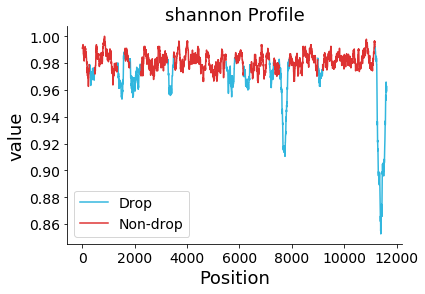

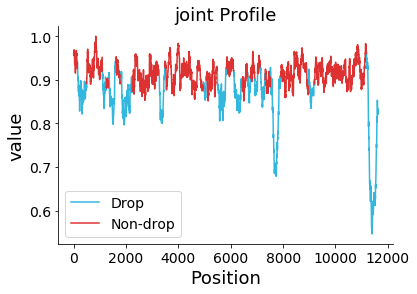

In [8]:
generate_profile(shannon, drops, 'seq_0', 'shannon')
plt.show()
generate_profile(joint, drops, 'seq_0', 'joint')
plt.show()

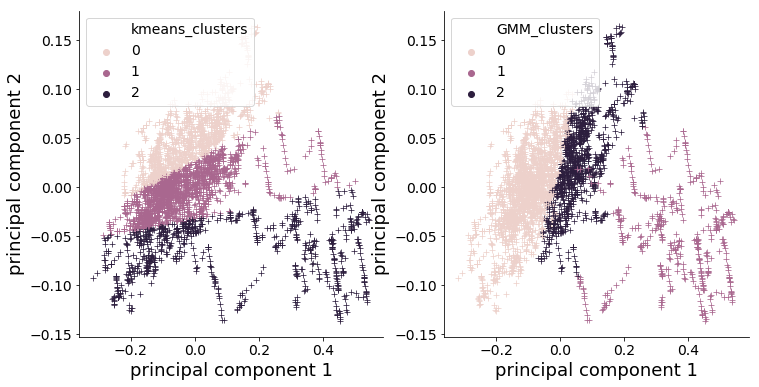

In [13]:
def generate_pca_classification(pc_df):

    with sns.plotting_context(rc={"font.size":14,"axes.titlesize":18,"axes.labelsize":18,
                              "xtick.labelsize":14,"ytick.labelsize":14,'y.labelsize':16}):

        f, axes = plt.subplots(1, 2, figsize=(12,6))
        # sns.scatterplot(x='principal component 1', y = 'principal component 2', hue='ground_truth',marker = '+', data=principalDf, ax=axes[0])
        sns.scatterplot(x='principal component 1', y='principal component 2', hue='kmeans_clusters', marker='+',
                        data=pc_df, ax=axes[0])
        sns.scatterplot(x='principal component 1', y='principal component 2', hue='GMM_clusters', marker='+', data=pc_df,
                        ax=axes[1])

        sns.despine()
generate_pca_classification(df)